Diagnosing Acute Inflammations of Bladder and Nephritis of Renal Pelvis Origin

This machine learning system can diagnose 2 acute inflammations of bladder. The medical dataset contains features and diagnoses of 2 diseases of the urinary system: Inflammation of urinary bladder and nephritis of renal pelvis origin. 

In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
df = pd.read_csv('Dataset.csv')
matrix = df.to_numpy()

We define some functions in order to randomly split this dataset in 2 parts : Training dataset and testing dataset, randomly without any biases
.

In [3]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]


n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data)

In [4]:
print_dataset('Train', train_data)

Dataset Train. Shape: (4270, 8)
[[40.4  0.   0.  ...  0.   0.   0. ]
 [36.6  0.   1.  ...  0.   0.   0. ]
 [41.1  1.   1.  ...  0.   0.   1. ]
 ...
 [37.1  0.   0.  ...  1.   1.   0. ]
 [36.3  0.   0.  ...  1.   1.   0. ]
 [37.3  0.   1.  ...  0.   0.   0. ]]


In [5]:
print_dataset('Test', test_data)

Dataset Test. Shape: (1068, 8)
[[37.4  0.   1.  ...  1.   1.   1. ]
 [40.   0.   0.  ...  0.   0.   0. ]
 [38.5  0.   1.  ...  1.   0.   1. ]
 ...
 [37.5  0.   0.  ...  0.   1.   0. ]
 [40.2  1.   1.  ...  0.   0.   1. ]
 [37.   0.   1.  ...  0.   0.   0. ]]


Now we define a machine learning model. In this case we define ANN as our model.

In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

input_size = 6
learning_rate = 0.01
num_iterations = 5830

class ANN(torch.nn.Module):

    def __init__(self):
        super(ANN, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    

# Instantiate the ANN model
model = ANN()

# Define loss function (binary cross-entropy loss)
criterion = nn.BCELoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


We define a threshold for classification purposes and define some functions to account for training accuracies and losses.

In the get_input_output() function, instead of wrapping the tensors with Variable class, we can use the syntax torch.tensor(data[:, :6], dtype=torch.float32).

In [7]:
def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)

def compute_accuracy(model, input_data, output):
    prediction = model(input_data).detach().numpy()
    n_samples = prediction.shape[0]
    prediction = decide_vectorized(prediction)
    equal = prediction == output.data.numpy()
    return 100. * equal.sum() / n_samples


def get_input_and_output(data):
    input_data = Variable(torch.tensor(data[:, :6], dtype=torch.float32))
    output1 = Variable(torch.tensor(data[:, 6], dtype=torch.float32)).view(-1, 1)  # Reshape to [batch_size, 1]
    output2 = Variable(torch.tensor(data[:, 7], dtype=torch.float32)).view(-1, 1)  # Reshape to [batch_size, 1]
    return input_data, output1, output2

input, output1, output2 = get_input_and_output(train_data)
test_input, test_output1, test_output2 = get_input_and_output(test_data)

import matplotlib.pyplot as plt
%matplotlib inline

diagnosis_title1 = 'Inflammation of Urinary Bladder'
diagnosis_title2 = 'Nephritis of Renal Pelvis Origin'

def plot_graphs(diagnosis_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()


def train_model(diagnosis_title, input_data, output, test_input, test_output):
    model = ANN()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = []
    accuracies = []
    epoch = 0
    n_samples, _ = input_data.shape
    for iteration in range(num_iterations):
            optimizer.zero_grad()
            prediction = model(input_data)
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 530 == 0:
                train_acc = compute_accuracy(model, input_data, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                epoch += 1
                print('epoch={}, loss={:.4f}, train_acc={}'.format(epoch, train_loss, to_percent(train_acc)))
    plot_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model


We train the model for 2 titles, i.e., Inflammation of urinary bladder and Nephritis of renal pelvis origin

epoch=1, loss=2.4044, train_acc=53.84%
epoch=2, loss=1.0058, train_acc=53.84%
epoch=3, loss=0.5691, train_acc=71.83%
epoch=4, loss=0.2820, train_acc=95.46%
epoch=5, loss=0.2684, train_acc=95.46%
epoch=6, loss=0.2588, train_acc=95.46%
epoch=7, loss=0.2517, train_acc=95.46%
epoch=8, loss=0.2463, train_acc=95.46%
epoch=9, loss=0.2421, train_acc=95.46%
epoch=10, loss=0.2387, train_acc=95.46%
epoch=11, loss=0.2360, train_acc=95.46%


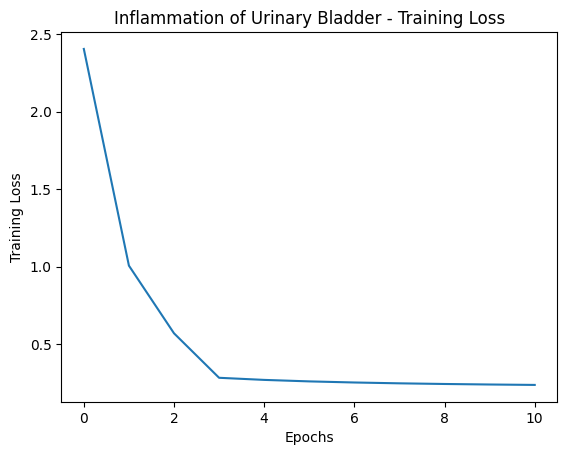

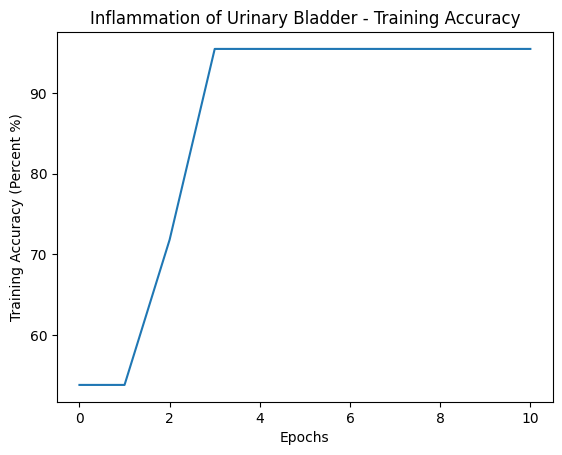


Testing Accuracy = 94.48%


In [8]:
model = train_model(diagnosis_title1, input, output1, test_input, test_output1)

epoch=1, loss=1.0469, train_acc=35.01%
epoch=2, loss=1.5742, train_acc=77.94%
epoch=3, loss=1.0242, train_acc=39.79%
epoch=4, loss=0.8431, train_acc=56.51%
epoch=5, loss=0.6109, train_acc=59.44%
epoch=6, loss=0.3856, train_acc=97.19%
epoch=7, loss=0.2570, train_acc=95.64%
epoch=8, loss=0.2469, train_acc=95.64%
epoch=9, loss=0.2383, train_acc=95.64%
epoch=10, loss=0.2311, train_acc=95.64%
epoch=11, loss=0.2248, train_acc=95.64%


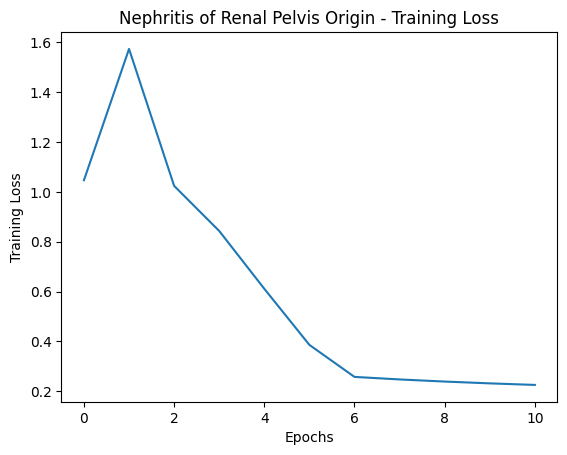

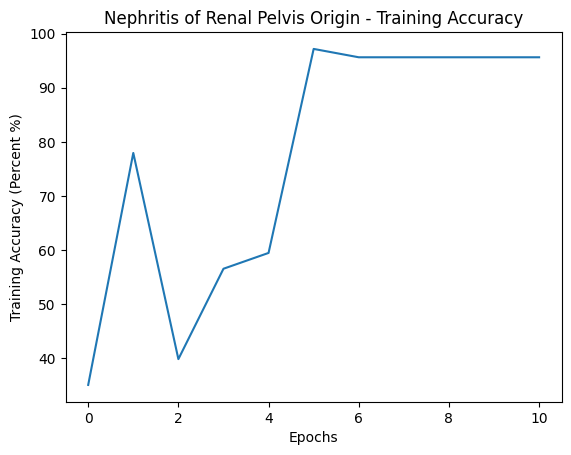


Testing Accuracy = 95.79%


In [9]:
model = train_model(diagnosis_title2, input, output2, test_input, test_output2)

FEDERATED LEARNING WITH A TRUSTED AGGREGATOR

In this demo, there are 4 hospitals. (The dataset will be split in 4, randomly.) There could be more hospitals. The 4 hospitals cannot share the cases of their patients as it is necessary to protect the privacy of patients. Hence, the ML model will be learned in a federated way.

How? Federated learning is iterated 1600 times. At each iteration, a copy of the shared model is sent to all the 4 hospitals. Each hospital trains its own local model with its own local dataset, in 5 local iterations. Each local model improves a little bit in its own direction. Then we compute the local losses and local accuracies to keep track of them and to make graphs of them. We send the local models to the trusted aggregator that will average all the model updates. This averaged model is the shared model that is sent to all the 4 hospitals at the begining of each iteration.

In this way, only the ML model will be shared. Whereas the local cases of each hospital will be kept private and they will be used to train model updates in a local way. Federated learning will protect the privacy of datasets in each hospital and at the same time, we will generate a more robust machine learning model, which will benefit all hospitals. This shared ML model preserves the privacy of individual patients and at the same time, reveals important statistics of stereotypical cases.

First, we start by creating the virtual workers that simulate the computers of each hospital. And then we establish communications among all of them.

We would have used PySyft for creating virtual workers but it is deprecated and is incompatible with the current version of pandas, numpy, etc so instead we create our own class for virtual workers

In [10]:
class VirtualWorker:
    def __init__(self, worker_id):
        self.id = worker_id
        self.workers = []

    def add_workers(self, workers):
        self.workers.extend(workers)

    def get_workers_names(self):
        return [worker.id for worker in self.workers]


def connect_workers(workers):
    for i, worker in enumerate(workers):
        other_workers = [workers[j] for j in range(len(workers)) if j != i]
        add_and_print_workers(worker, other_workers)

In order to simulate this process, we start by dividing the dataset in 4 parts, randomly. And then we send each part to each hospital. Each part is composed of the features, the diagnosis for disease 1, and the diagnosis for disease 2.

In [11]:
import torch as th
from torch import nn, optim

n_hospitals = 4
hospitals = []
for i in range(n_hospitals):
    hospital_name = 'hospital{}'.format(i)
    hospital = VirtualWorker(worker_id = hospital_name)
    hospitals.append(hospital)
secure_worker = VirtualWorker(worker_id = "secure_worker")

def get_workers_names(workers):
    return [worker.id for worker in workers]

def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

for i in range(n_hospitals):
    workers = [hospitals[i2] for i2 in range(n_hospitals) if i2 != i] + [secure_worker]
    add_and_print_workers(hospitals[i], workers)
add_and_print_workers(secure_worker, hospitals)


workers of hospital0 = ['hospital1', 'hospital2', 'hospital3', 'secure_worker']
workers of hospital1 = ['hospital0', 'hospital2', 'hospital3', 'secure_worker']
workers of hospital2 = ['hospital0', 'hospital1', 'hospital3', 'secure_worker']
workers of hospital3 = ['hospital0', 'hospital1', 'hospital2', 'secure_worker']
workers of secure_worker = ['hospital0', 'hospital1', 'hospital2', 'hospital3']


In [12]:
n_samples = train_data.shape[0]
samples_per_hospital = int((n_samples + 0.5) / n_hospitals)
hospital_features = []
hospital_targets1 = []
hospital_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_hospitals):
    train_data2 = train_data[i * samples_per_hospital:(i + 1) * samples_per_hospital].clone().detach().requires_grad_(True)
    features = train_data2[:, :6].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 6][:, None].clone().detach()
    targets2 = train_data2[:, 7][:, None].clone().detach()
    hospital_features.append(features)
    hospital_targets1.append(targets1)
    hospital_targets2.append(targets2)

print(model)

ANN(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)


We define some functions to train the machine learning model in a federated way while keeping account of the training loss and the training accuracy, for each hospital separately.

The whole process is done in a trusted aggregator, in 1600 iterations. (We can vary the number of iterations.) At each iteration, a copy of the shared model is sent to all the 4 hospitals. Each hospital trains its own local model with its own local dataset, in 5 local iterations. (We can vary the number of local iterations.) Each local model improves a little bit in its own direction. Then we compute the local losses and local accuracies to keep track of them. So, we will able to create graphs of the learning curves: Training Losses versus Iterations and Training Accuracies versus Iterations. We send the local models to the trusted aggregator that will average all the model updates. This averaged model is the shared model that is sent to all the 4 hospitals at the begining of each iteration.

Finally, we compute the testing accuracy of the final model with the testing dataset we separated since the beginning.

In [13]:
import copy

def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples

    # for i in range(n_samples):
    #     # Adjust prediction threshold for ANN
    #     p = 1. if prediction[i] >= threshold else 0.  # You need to define 'threshold' based on your problem
    #     e = 1. if p == output[i] else 0.
    #     s += e
    # return 100. * s / n_samples

iterations = 1600 #2000
worker_iterations = 4

def federated_learning(diagnosis_title, hospital_features, hospital_targets, test_input, test_output):
    model = ANN()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    losses = [[] for _ in range(n_hospitals)]
    accuracies = [[] for _ in range(n_hospitals)]

    for iteration in range(iterations):
        models = [copy.deepcopy(model) for _ in range(n_hospitals)]  # Use deepcopy
        optimizers = [optim.SGD(params=models[i].parameters(), lr=learning_rate) for i in range(n_hospitals)]
        last_losses = []

        for worker_iteration in range(worker_iterations):
            for i in range(n_hospitals):
                optimizers[i].zero_grad()
                prediction = models[i](hospital_features[i])
                loss = criterion(prediction, hospital_targets[i])
                loss.backward()
                optimizers[i].step()
                last_losses.append(loss.item())

        for i in range(n_hospitals):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], hospital_features[i], hospital_targets[i])
            accuracies[i].append(train_acc)

        avg_weight = sum([models[i].linear.weight for i in range(n_hospitals)]) / n_hospitals
        model.linear.weight.data = avg_weight.data

        avg_bias = sum([models[i].linear.bias for i in range(n_hospitals)]) / n_hospitals
        model.linear.bias.data = avg_bias.data

        if iteration % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = ['{:.2f}%'.format(accuracies[i][-1]) for i in range(n_hospitals)]
            print(f'Iteration={iteration}, losses={losses_str}, accuracies={accuracies_str}')

    plot_federated_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_federated_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {:.2f}%'.format(test_acc))
    return model

We train the model for 2 titles, i.e., Inflammation of urinary bladder and Nephritis of renal pelvis origin

Iteration=0, losses=['5.1783', '5.3285', '5.3962', '5.2709'], accuracies=['52.48%', '54.26%', '55.01%', '53.61%']
Iteration=100, losses=['1.4382', '1.4117', '1.4026', '1.4419'], accuracies=['52.48%', '54.26%', '55.01%', '53.61%']
Iteration=200, losses=['0.9488', '0.9408', '0.9408', '0.9644'], accuracies=['52.48%', '54.26%', '55.01%', '53.61%']
Iteration=300, losses=['0.4842', '0.4799', '0.4827', '0.4861'], accuracies=['72.73%', '71.70%', '71.79%', '71.04%']
Iteration=400, losses=['0.2945', '0.2794', '0.2799', '0.2630'], accuracies=['95.50%', '94.94%', '95.13%', '96.25%']
Iteration=500, losses=['0.2858', '0.2704', '0.2711', '0.2521'], accuracies=['95.50%', '94.94%', '95.13%', '96.25%']
Iteration=600, losses=['0.2790', '0.2634', '0.2642', '0.2435'], accuracies=['95.50%', '94.94%', '95.13%', '96.25%']
Iteration=700, losses=['0.2735', '0.2579', '0.2588', '0.2366'], accuracies=['95.50%', '94.94%', '95.13%', '96.25%']
Iteration=800, losses=['0.2691', '0.2534', '0.2545', '0.2309'], accuracies

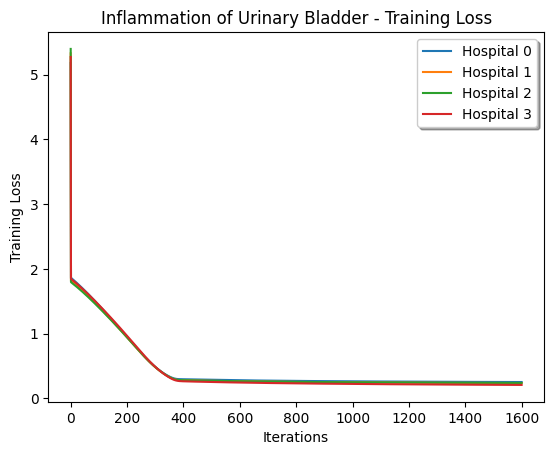

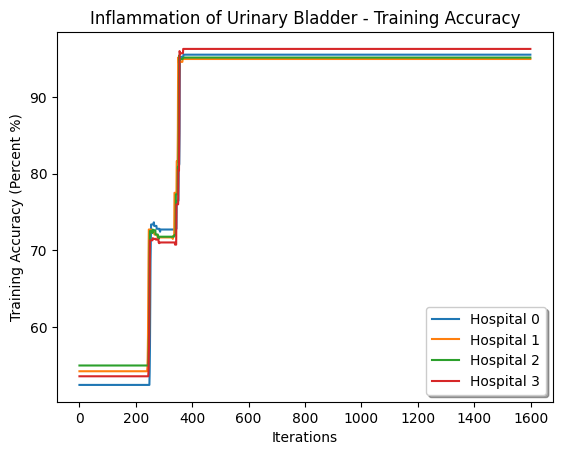


Testing Accuracy = 94.48%


In [14]:
m1 = federated_learning(diagnosis_title1, hospital_features, hospital_targets1, test_input, test_output1)

Iteration=0, losses=['7.6228', '7.7887', '7.7520', '7.4935'], accuracies=['64.76%', '67.10%', '65.70%', '63.45%']
Iteration=100, losses=['1.7031', '1.6477', '1.6698', '1.7705'], accuracies=['64.76%', '65.98%', '65.70%', '63.45%']
Iteration=200, losses=['1.4954', '1.4470', '1.4688', '1.5534'], accuracies=['64.76%', '65.98%', '65.70%', '63.45%']
Iteration=300, losses=['1.1076', '1.0721', '1.0913', '1.1489'], accuracies=['64.76%', '65.98%', '65.70%', '63.45%']
Iteration=400, losses=['0.8987', '0.8696', '0.8878', '0.9303'], accuracies=['64.76%', '65.98%', '65.70%', '63.45%']
Iteration=500, losses=['0.7259', '0.7013', '0.7183', '0.7489'], accuracies=['64.57%', '65.98%', '65.60%', '62.89%']
Iteration=600, losses=['0.5547', '0.5333', '0.5481', '0.5681'], accuracies=['69.35%', '71.23%', '70.57%', '68.32%']
Iteration=700, losses=['0.3956', '0.3748', '0.3863', '0.3974'], accuracies=['75.54%', '77.69%', '76.19%', '73.57%']
Iteration=800, losses=['0.2771', '0.2506', '0.2570', '0.2602'], accuracies

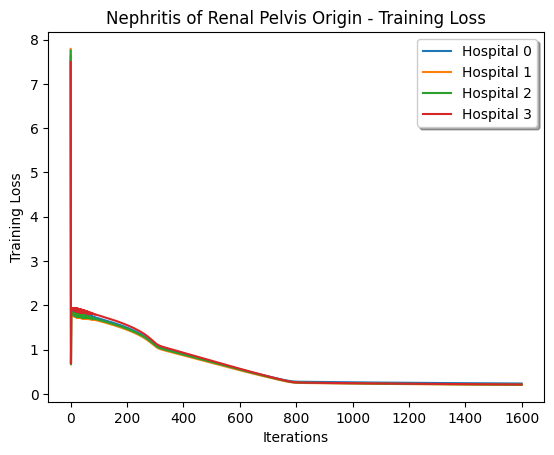

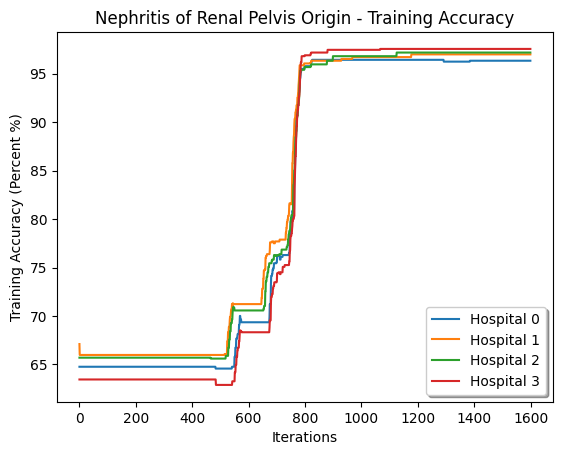


Testing Accuracy = 97.10%


In [15]:
m2 = federated_learning(diagnosis_title2, hospital_features, hospital_targets2, test_input, test_output2)

The learning curves Training Losses versus Iterations and Training Accuracies versus Iterations have 4 colors for all 4 hospitals. Each graph has 4 curves of different colors: Blue, orange, green, and red. The curves are not lines; they are rather regions. Why? Because each iteration of federated learning is complex: First, 5 local iterations in each virtual worker (each hospital) to train each local model. Each local model improves a little bit in its own direction. Then, the 4 different models are sent to the trusted aggregator that averages them. Finally, the averaged model is sent back to the 4 hospitals. Such averaged model can have lower performance in comparison to the local models, which are more locally adapted to the local datasets. That's why the progress in the learning curves goes back and forth. Moreover, the graph has 1000 iterations. That's why the curves becomes regions. Because the curves go back and forth too often and are quite dense.


Below is the validation process for the model m1 and m2 for disease 1 and disease 2

In [16]:
ip = np.array([[37.7,0,1,0,0,1,0,1]], dtype = np.float32)
validation = Variable(torch.tensor(ip[:, :6], dtype=torch.float32))
pred = m1(validation)
print('yes' if decide(pred) else 'no')

no


In [17]:
ip1 = np.array([[38.9,0,1,1,0,1,0,1]], dtype = np.float32)
validation1 = Variable(torch.tensor(ip[:, :6], dtype=torch.float32))
pred1 = m2(validation1)
print('yes' if decide(pred1) else 'no')

no


Then we dunp our federated models in a pickle file to access them in the GUI of this project

In [18]:
with open('model1.pkl','wb') as files:
    pickle.dump(m1,files)

In [19]:
with open('model2.pkl','wb') as files:
    pickle.dump(m2,files)